In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def show_in_notebook(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()

Read the labeled image

In [2]:
img = cv2.imread('../img/board/labeled.png')
h, w, ch = img.shape

green_low = np.array([0, 220, 0])
green_high = np.array([10, 255, 10])

mask = cv2.inRange(img, green_low, green_high)

coord = cv2.findNonZero(mask)
coord_xy = [[dot[0][0],dot[0][1]] for dot in coord]
np_coord = np.array(coord_xy)

four_point_kmeans = KMeans(n_clusters=4, random_state=0).fit(np_coord)

Visualize

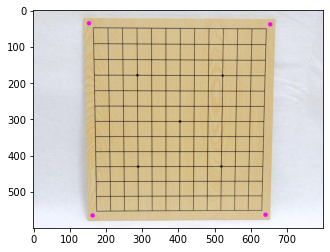

In [3]:
vis1 = cv2.imread('../img/board/raw.jpeg')
for dot in four_point_kmeans.cluster_centers_:
    vis1 = cv2.circle(vis1, (int(dot[0]),int(dot[1])), 6, (255, 0, 255), -1)
show_in_notebook(vis1)

Do Perspective Transformation

In [4]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    rect[0] = pts[0]
    rect[1] = pts[2]
    rect[2] = pts[1]
    rect[3] = pts[3]
    return rect

def four_point_transform(image, pts = four_point_kmeans.cluster_centers_):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    min_len = min(maxHeight, maxWidth)

    dst = np.array([
        [0, 0],
        [min_len - 1, 0],
        [min_len - 1, min_len - 1],
        [0, min_len - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (min_len, min_len))

    # return the warped image
    return warped

visualize

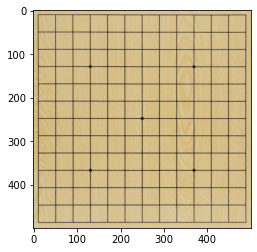

In [9]:
vis2 = cv2.imread('../img/board/raw.jpeg')
warped = four_point_transform(vis2, four_point_kmeans.cluster_centers_)
show_in_notebook(warped)

Find Edges in Rectified Image

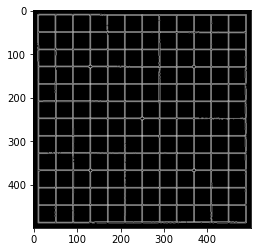

In [11]:
newbaseImg = warped.copy()

gray = cv2.cvtColor(newbaseImg, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,200,320,apertureSize = 3)
show_in_notebook(edges)

Hough Transformation To Find Lines

In [16]:
lines = cv2.HoughLines(edges,1,np.pi/90,110)

visualize

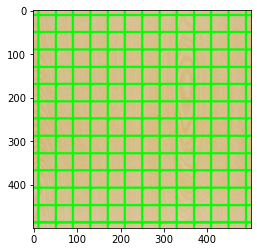

In [17]:
vis3 = warped.copy()
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    cv2.line(vis3,(x1,y1),(x2,y2),(0,255,0),2)

show_in_notebook(vis3)

Group Vertical and Horizontal Lines

In [18]:
hori = []
verti = []

for line in lines:
    rho, theta = line[0]
    if theta <= 1.8 and theta >= 1.2:
        verti.append(line)
    else:
        hori.append(line)

visualize

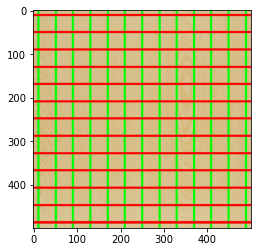

In [19]:
vis4 = warped.copy()

for line in hori:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    cv2.line(vis4,(x1,y1),(x2,y2),(0,255,0),2)
for line in verti:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    cv2.line(vis4,(x1,y1),(x2,y2),(0,0,255),2)
show_in_notebook(vis4)

Find Intersections

In [20]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.
    Returns closest integer pixel locations.
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]

intersections = []
for xline in hori:
    for yline in verti:
        intersections.append(intersection(xline, yline))

visualize

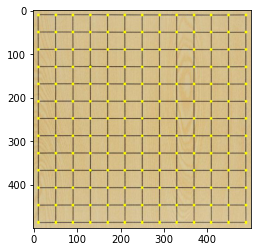

In [21]:
vis5 = warped.copy()

for intersect in intersections:
    x0 = intersect[0]
    y0 = intersect[1]

    img = cv2.circle(vis5, (x0, y0), radius=2, color=(0, 255, 255), thickness=-1)
show_in_notebook(vis5)

KMeans To Find Accurate Intersection Position

In [22]:
X = np.array(intersections)
intersection_kmeans = KMeans(n_clusters=169, random_state=0).fit(X)

visualize

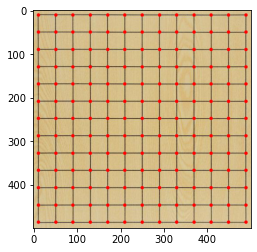

In [23]:
vis6 = warped.copy()

coord_array = np.array([[int(x[0]),int(x[1])] for x in intersection_kmeans.cluster_centers_])
for center in coord_array:
    vis6 = cv2.circle(vis6, [int(center[0]), int(center[1])], 4, (0,0,255), -1)
show_in_notebook(vis6)


Construct Lookup Table

In [24]:
sorted_cord = coord_array[coord_array[:,0].argsort()]
coord_lookup = []

for i in range(13):
    row_sorted = sorted_cord[13*i:13*i+13]
    rc_sorted = row_sorted[row_sorted[:,1].argsort()]
    x_row = []
    for j in range(13):
        x_row.append(rc_sorted[j])
    coord_lookup.append(x_row)
coord_lookup = np.array(coord_lookup)

Mapping Image to List

In [25]:
step4 = cv2.imread('../img/board/steps.png')
rect_step4 = four_point_transform(step4, four_point_kmeans.cluster_centers_)

Visualize

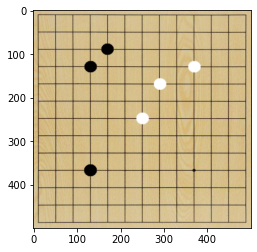

In [26]:
show_in_notebook(rect_step4)

Use Hough Circle to Find Circles

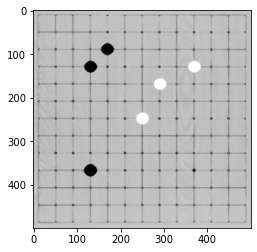

In [54]:
step_gray = cv2.cvtColor(rect_step4, cv2.COLOR_BGR2GRAY)
step_gray = cv2.medianBlur(step_gray, 5)
show_in_notebook(step_gray)

rows = step_gray.shape[0]

circles = cv2.HoughCircles(step_gray, cv2.HOUGH_GRADIENT, 1, rows / 19,
                           param1=80, param2=23,
                           minRadius=10, maxRadius=30)

Visualize

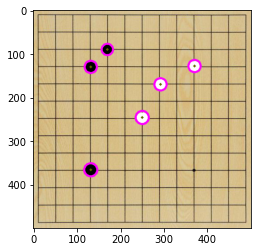

In [55]:
vis7 = rect_step4.copy()

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(vis7, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv2.circle(vis7, center, radius, (255, 0, 255), 3)
show_in_notebook(vis7)

Find the Index on Board for Circles

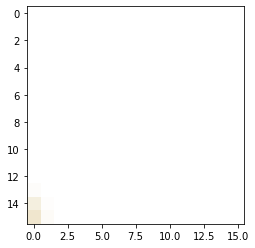

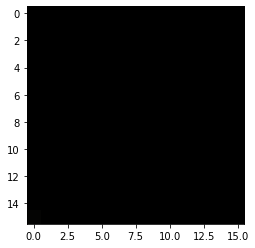

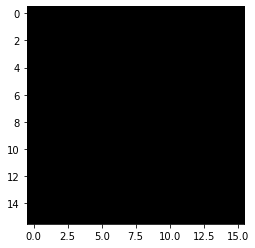

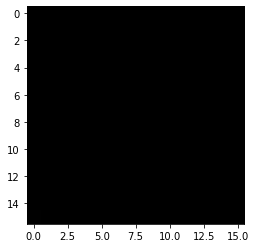

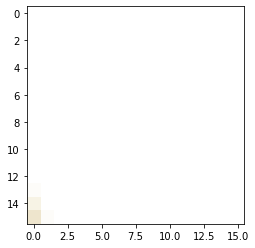

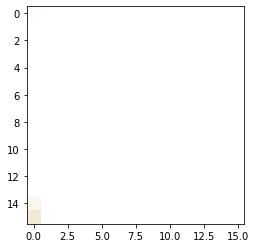

In [65]:
r = 8
mean_row = []
for row in coord_lookup:
    row_sum = sum(row[:, 0])
    mean_row.append(row_sum//13)

mean_col = []
for i in range(13):
    col = coord_lookup[:, i]
    col_sum = sum(col[:, 1])
    mean_col.append(col_sum//13)

stone_map = np.zeros((13, 13))

vis8 = rect_step4.copy()

for circle in circles[0, :]:

    col_val = circle[0]
    row_val = circle[1]

    row_index = -1
    col_index = -1


    for i in range(len(mean_row)):
        if abs(row_val - mean_row[i]) <= 8:
            row_index = i
            break
    for i in range(len(mean_col)):
        if abs(col_val - mean_col[i]) <= 8:
            col_index = i
            break


    real_row, real_col = coord_lookup[row_index, col_index]
    roi = vis8[real_row - r: real_row + r, real_col - r: real_col + r]
    show_in_notebook(roi)
    width, height = roi.shape[:2]
    mask = np.zeros((width, height, 3), roi.dtype)
    cv2.circle(mask, (int(width / 2), int(height / 2)), r, (255, 255, 255), -1)
    dst = cv2.bitwise_and(roi, mask)
    data = []
    for k in range(3):
        channel = dst[:, :, k]
        indices = np.where(channel != 0)[0]
        if len(indices) == 0:
            data.append(0)
        else:
            color = np.mean(channel[indices])
            data.append(int(color))

    if sum(data)/len(data) < 50:
        stone_map[row_index][col_index] = 1
    elif sum(data)/len(data) > 200:
        stone_map[row_index][col_index] = 2
    else:
        stone_map[row_index][col_index] = 0